# Day 3 | Logistic regression

logistic regression是一個分類模型，是在機器學習分類問題時相當基礎的一個模型，其實整個模型的架構簡單來說就是將一個linear regression的模型放入一個sigmoid函數中，將結果輸出為0~1之間的數值，而我們再用一個threshhlod來去決定如何分類，相關資源如下：
1. [資料分析&機器學習] 第3.3講：線性分類-邏輯斯回歸(Logistic Regression) 介紹 : [link](https://medium.com/@yehjames/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC3-3%E8%AC%9B-%E7%B7%9A%E6%80%A7%E5%88%86%E9%A1%9E-%E9%82%8F%E8%BC%AF%E6%96%AF%E5%9B%9E%E6%AD%B8-logistic-regression-%E4%BB%8B%E7%B4%B9-a1a5f47017e5)
2. 李宏毅老師課程：[link](https://www.youtube.com/watch?v=hSXFuypLukA&list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&index=10)
3. 目前最火的100 days ML code 挑戰 Avik-Jain：[link](https://github.com/Avik-Jain/100-Days-Of-ML-Code/blob/master/Code/Day%206%20Logistic%20Regression.md)

而本次將使用kaggle鐵達尼號作為logistic regression資料：
https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster/data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
train_df = pd.read_csv('all/train.csv')
test_df = pd.read_csv('all/test.csv')

In [7]:
# train_df.info()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 確認缺失值（利用heatMap)

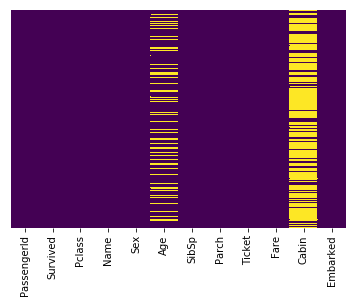

In [10]:
sns.heatmap(train_df.isnull(), yticklabels= False, cmap = 'viridis', cbar=False)
## 可以透過heatmap看出Cabin預age的資訊缺失的相當多，

## EDA

確認存活人數的比例，利用seaborn countplot來確認。

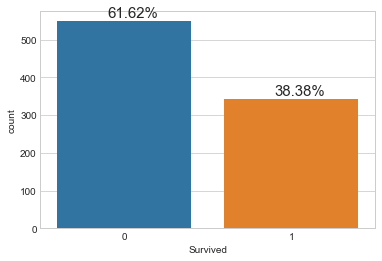

In [38]:
sns.set_style('whitegrid')
count_plot = sns.countplot(data = train_df, x = 'Survived')
for i, value in enumerate(train_df.Survived.value_counts()):
    count_plot.text(x = i-0.1, y =value+10, s = '{}%'.format(round(value/len(train_df)*100,2)), fontsize = 15)

### 由此圖可以看出大部分的人(6成)的人都未能存活

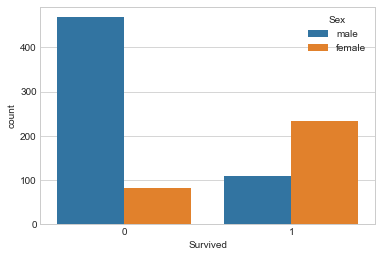

In [45]:
sns.set_style('whitegrid')
count_plot = sns.countplot(data = train_df, hue = 'Sex', x = 'Survived')

/Users/apple/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


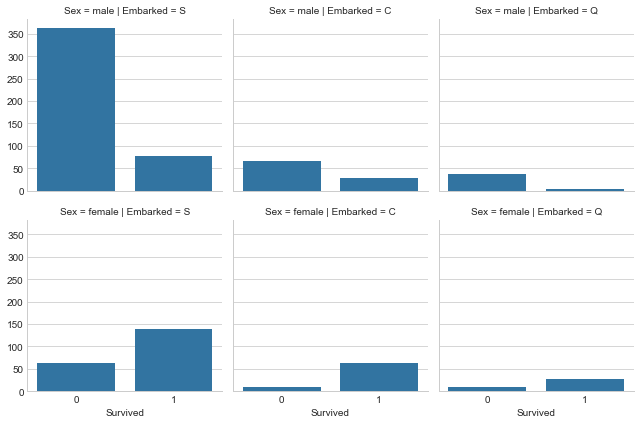

In [47]:
sns.set_style('whitegrid')
# count_plot = sns.countplot(data = train_df, hue = 'Embarked', x = 'Survived')
g = sns.FacetGrid(data = train_df, col='Embarked', row = 'Sex')
g = g.map(sns.countplot, 'Survived')

### 再針對各不同地區上船資訊加上性別來分析，大多罹難的的都是在Southampton上船的男性

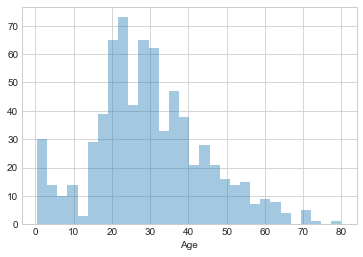

In [51]:
sns.distplot(train_df.Age.dropna(), kde= False, bins = 30)
### 由此區間可以看出約呈現一個常態分佈，大部分的乘客都是介於20-30碎的青壯年

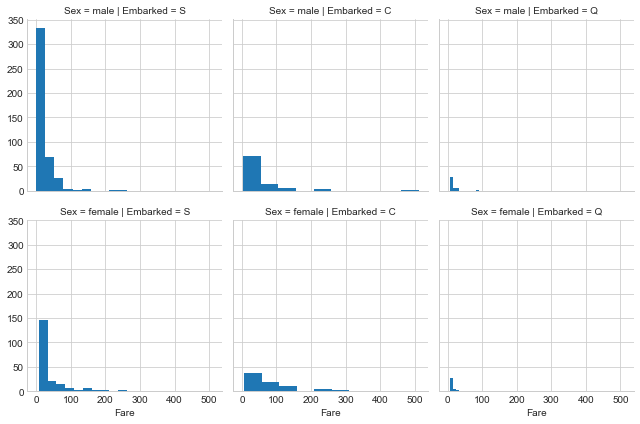

In [61]:
sns.set_style('whitegrid')
g = sns.FacetGrid(data = train_df, col='Embarked', row = 'Sex')
g = g.map(plt.hist, 'Fare')

## 另外又從此表看出由Southampton上船的男性佔沒有買票的多數

# Clean data

接下來我們來清理資料，由上面的heatmap可以看出Cabin的資料缺失值太多，因此我將它轉成有Cabin與沒有Cabin，另外年齡做後續處理。

Pclass_1 average age:  38
Pclass_2 average age:  29
Pclass_3 average age:  25


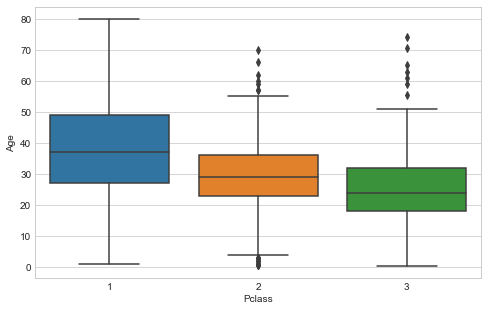

In [96]:
plt.figure(figsize = (8,5))
sns.boxplot(data = train_df, x = "Pclass", y = "Age")
## 我們可以假設年齡與艙等也是有關係的，因此我們利用各艙等年齡的平均來補植
print('Pclass_1 average age: ', int(train_df[train_df.Pclass == 1].Age.mean()))
print('Pclass_2 average age: ', int(train_df[train_df.Pclass == 2].Age.mean()))
print('Pclass_3 average age: ', int(train_df[train_df.Pclass == 3].Age.mean()))


In [103]:
## 確認如果有Cabin資料則給1，沒有則給0
def cabin_check(cabin):
    if pd.isnull(cabin):
        return 0
    else:
        return 1
    
    
## 確認艙等後回傳該艙等年齡平均值
def Age_chcek(pclass_age, df = train_df):
    pclass = pclass_age[0]
    age = pclass_age[1]
    if pd.isnull(age):
        if pclass == 1:
            return 38
        if pclass == 2:
            return 29
        else:
            return 25
    else:
        return age

In [104]:
train_df.Cabin = train_df.Cabin.apply(cabin_check)
train_df.Age = train_df[['Pclass', 'Age']].apply(Age_chcek, axis = 1)

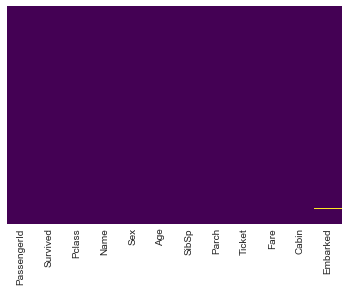

In [107]:
sns.heatmap(train_df.isnull(), yticklabels= False, cmap = 'viridis', cbar=False)
### 資料已經清理乾淨了，而剩下一筆是Embark的缺失值，因此直接drop
train_df.dropna(inplace = True)

### 轉換類別型資料

In [114]:
train_df.head()
### 像是姓名，船票等文字資料沒有辦法使用，因此先捨棄，而像性別，上船地點等可以轉換成dummy variable

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


In [115]:
train_df.drop(['Name', 'Ticket'], axis = 1, inplace = True)

In [118]:
train_df = pd.get_dummies(train_df, drop_first= True)
train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,1


# Logistic Regresstion

首先import必要的套件：

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [124]:
X = train_df.drop(['Survived'], axis = 1)
y = train_df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set number: ", len(X_train))
print("Testing set number: ", len(X_test))

Training set number:  711
Testing set number:  178


In [125]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [126]:
predict = logistic_model.predict(X_test)

## Evaluation
可以藉由scikit-learn的confusion-matrix 以及 classodication_report函式來評估準確度
1. Confusion matrix : [如何辨別機器學習模型的好壞？秒懂Confusion Matrix](https://www.ycc.idv.tw/confusion-matrix.html)

In [127]:
from sklearn.metrics import confusion_matrix, classification_report

In [129]:
print(confusion_matrix(y_test, predict))

[[89 20]
 [17 52]]


In [130]:
print(classification_report(y_test, predict))

             precision    recall  f1-score   support

          0       0.84      0.82      0.83       109
          1       0.72      0.75      0.74        69

avg / total       0.79      0.79      0.79       178



##### 可以看出此資料集透過簡單的整理後，直接使用logistic regression來做分類就可以得出一個不差的結果
而其實有關線性回歸模型，不管是linear regression or logistic regression 可能都會碰到的問題就是overfitting 或是 underfitting 的問題，應該如何調整與權衡，預計將放在Day4來討論。
相關資料：
1. https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-3-4-the-c05b8ba3b36f